# Importing Libraries:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download("stopwords")
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score
from gensim import models
from gensim.models import KeyedVectors
import wordcloud
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Loading dataset:

In [2]:
df = pd.read_csv('mbti_1.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


# Preprocessing:

1. Remove urls in text.
2. Remove punctuations.
3. Convert to lower case.
4. Remove MBTI tags in posts itself.
5. Lemmatize the text.
6. Remove words which are stopwords or have length <= 2.

In [3]:
stopwords = set(nltk.corpus.stopwords.words("english"))
MBTItypes = set(df["type"])
MBTItypes = set([x.lower() for x in MBTItypes])
print(stopwords)
print(MBTItypes)

{"should've", 've', 'an', "isn't", 'them', 'up', 'he', 'mustn', 'most', 'now', 'on', 'hasn', 'wouldn', 'been', "mightn't", 'herself', 'her', 'into', 'after', 'his', 'why', "shouldn't", 'a', "needn't", "won't", 'any', 'doesn', 'mightn', 'only', "that'll", 'yourself', 'this', 'will', 'wasn', 'they', 'didn', 'shouldn', "don't", 'of', "shan't", 'each', "you'll", 'there', 'both', 'am', 'with', 'once', 'so', "couldn't", 'against', 'me', 'just', "wouldn't", 'y', 'that', "weren't", 'if', 'weren', 'under', 'don', 'she', 'itself', 'few', 'too', 'shan', 'i', 'which', 'have', 'above', 'themselves', 'about', 'such', "wasn't", 'ma', 'further', 'ain', 'it', 'but', 'all', "haven't", 'aren', 'haven', 'couldn', 'does', 'is', 'm', 'own', 'its', 'our', 'off', 'between', 'isn', 'these', 'who', 'hadn', "you've", 'o', 'below', 'out', 'and', 'same', 'should', 'needn', 'having', 'how', 'be', 'do', 'at', 'where', "doesn't", 'by', "you're", 'being', 'very', 'are', 'more', 'we', 'what', 'then', 'when', 'before', 

In [4]:
newLabelCol = [] # Will store MBTI type
newPostsCol = [] # Will store corresponding post
indicator0Col = [] # Indicator 1
indicator1Col = [] # Indicator 2
indicator2Col = [] # Indicator 3
indicator3Col = [] # Indicator 4
lemmatizer = WordNetLemmatizer()

for index, row in df.iterrows(): # for each row.
    
    lab = row['type']   # MBTI type
    indicator0 = lab[0] # extract indicator1
    indicator1 = lab[1] # extract indicator2
    indicator2 = lab[2] # extract indicator2
    indicator3 = lab[3] # extract indicator2
    
    # Remove urls
    posts = re.sub(r'http\S+', '', row["posts"])
    
    # Remove punctuation and replace with ''
    posts = re.sub(re.compile(r"[^a-z\s]"), '', posts)
    
    # Convert to lower case.
    posts = posts.lower()
    
    # Remove MBTI tags in posts itself.
    for mbti in MBTItypes:
        posts = posts.replace(mbti.lower(), "")
    
    # Remove stopwords.
    formattedPosts = []
    for x in word_tokenize(posts):
        # Lemmatize the token
        x = lemmatizer.lemmatize(x)
        x = x.lower() # Convert to lower case
        if x not in stopwords and len(x) > 2:
            formattedPosts.append(x)
            
    posts = " ".join(formattedPosts)
        
    # Create a row.
    newLabelCol.append(lab)
    newPostsCol.append(posts)
    indicator0Col.append(indicator0)
    indicator1Col.append(indicator1)
    indicator2Col.append(indicator2)
    indicator3Col.append(indicator3)

In [5]:
# Create a dataframe from it.
df = pd.DataFrame({"type": newLabelCol, 
                   "posts": newPostsCol, 
                   "I or E": indicator0Col,
                   "N or S": indicator1Col,
                   "T or F": indicator2Col,
                   "J or P": indicator3Col
                  })
df.head()

,type,posts,I or E,N or S,T or F,J or P
0,INFJ,moment sportscenter top ten play prankshat lif...,I,N,F,J
1,ENTP,finding lack post alarmingex boring position o...,E,N,T,P
2,INTP,ood one course say know thats blessing curseoe...,I,N,T,P
3,INTJ,ear enjoyed conversation day soteric gabbing n...,I,N,T,J
4,ENTJ,oure firedhats another silly misconception hat...,E,N,T,J


# Data Visualization:

In [5]:
# groupby type.
groupedByType = df.groupby("type")

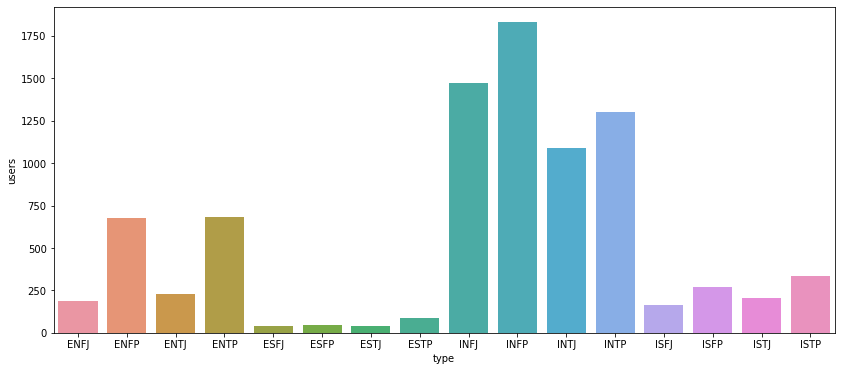

In [6]:
# plotting distribution of classes.
plt.figure(figsize=(14,6))
sns.barplot(x=groupedByType.count().index, y=groupedByType.count()["posts"])
plt.ylabel('users')
plt.show()

##### Observation: Data is imbalanced. INFP, INFJ, INTJ, INTP have most number of posts while ESFJ, ESFP, ESTJ have least number of posts.

In [21]:
# Plots a word cloud given a list of strings.
def showWordCloud(listOfStrings, ax, title=""):
    strings = ""
    for x in listOfStrings:
        strings += x # Accumulate into a single string
        
    # Create a wordcloud
    wordCloud = wordcloud.WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(strings)

    # plot it.
    ax.set_title(title.upper())
    ax.imshow(wordCloud)
    ax.axis("off")

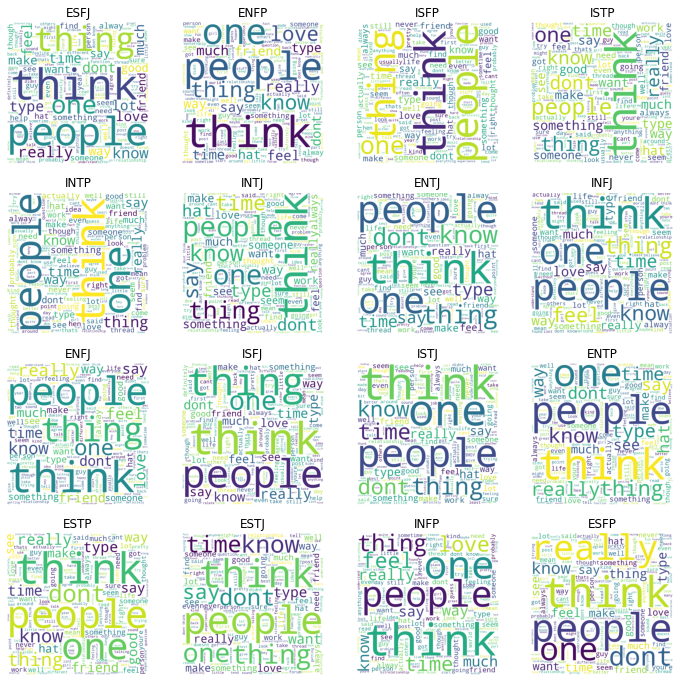

In [22]:
# We will plot a word cloud for every MBTI type.
# Create subplots.
_, axs = plt.subplots(4, 4, figsize=(12,12))


i = 0
j = 0

# Loop through each MBTItype and plot a wordcloud.
for types in MBTItypes:
    showWordCloud(groupedByType.get_group(types.upper())["posts"], axs[i//4, j%4], types)
    i += 1
    j += 1

plt.show()

##### Observation: Some words are common across the classes like: people, think, know, really, one. So these words may not help in classifying the classes.

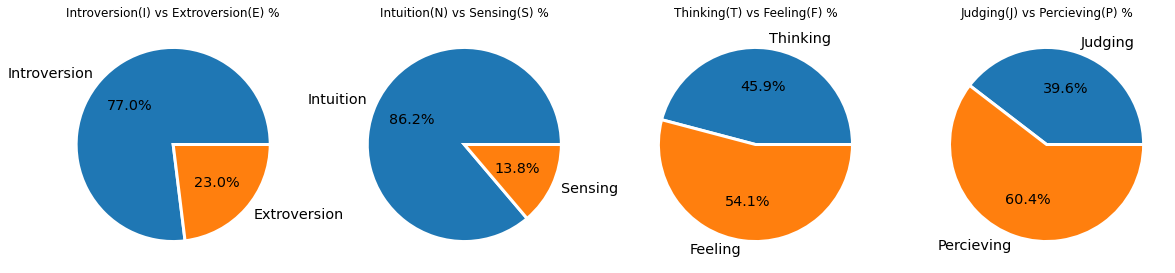

In [23]:
length = df.shape[0] # number of rows in dataframe.

fig, ax = plt.subplots(1, 4, figsize=(20,6)) # 4 subplots.

# plot a pie chart for I (Introversion) vs E (Extroversion)
data = [sum(df["I or E"] == "I")/length, sum(df["I or E"] == "E")/length]
ax[0].set_title("Introversion(I) vs Extroversion(E) %")
ax[0].pie(data, labels=["Introversion", "Extroversion"], autopct='%.1f%%',
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
       textprops={'size': 'x-large'})

# plot a pie chart for N (Intuition) vs E (Sensing)
data = [sum(df["N or S"] == "N")/length, sum(df["N or S"] == "S")/length]
ax[1].set_title("Intuition(N) vs Sensing(S) %")
ax[1].pie(data, labels=["Intuition", "Sensing"], autopct='%.1f%%',
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
       textprops={'size': 'x-large'})

# plot a pie chart for T (Thinking) vs F (Feeling)
data = [sum(df["T or F"] == "T")/length, sum(df["T or F"] == "F")/length]
ax[2].set_title("Thinking(T) vs Feeling(F) %")
ax[2].pie(data, labels=["Thinking", "Feeling"], autopct='%.1f%%',
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
       textprops={'size': 'x-large'})

# plot a pie chart for J (Judging) vs P (Percieving)
data = [sum(df["J or P"] == "J")/length, sum(df["J or P"] == "P")/length]
ax[3].set_title("Judging(J) vs Percieving(P) %")
ax[3].pie(data, labels=["Judging", "Percieving"], autopct='%.1f%%',
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
       textprops={'size': 'x-large'})

plt.show()

##### Observation: There a very few posts which have S as an indictaor in MBTI type. A lot of posts have I as an indicator in MBTI type.

# Model Training:

### Baseline model:

1. This model will use TFIDF features to classify between the 16 MBTI types.
2. We will first split the dataframe into train and test set.
3. Then we vectorize the train and test set using TFIDF vectorizer which converts text into numbers which can be used for training.
4. We will use accuracy as a metric and we will also use confusion matrix to see TP, FP, TN, FN.
5. Model to be trained will be Logistic Regression and Decision Trees.

In [6]:
# Split the train data into training and testing set. test set has size 30% of original data.
dfTrain, dfTest, yTrain, yTest = sklearn.model_selection.train_test_split(df["posts"], 
                                                                          df["type"], 
                                                                          test_size=0.3, 
                                                                          random_state=0)

In [7]:
# Build tfIdf features.
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words='english', 
                                                             max_features=10000,
                                                             min_df=50,
                                                             max_df=0.80)
dfTrain = vectorizer.fit_transform(dfTrain)
dfTest = vectorizer.transform(dfTest)

In [8]:
# Takes in true and predicted label and label info to print a confusion matrix neatly.
def plotConfusionMatrix(y_true, y_pred, labels=[elem.upper() for elem in MBTItypes]):
    
    plt.figure(figsize=(16,16))
    
    # Generate confusion matrix
    cfMatrix = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=labels)
    
    # Convert matrix to dataframe
    cfDataframe = pd.DataFrame(cfMatrix/np.sum(cfMatrix), index=labels, columns=labels)
    
    # plot heatmap
    sns.heatmap(cfDataframe, annot=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

### 1. Logistic Regression

In [9]:
TestAccuracies = []
TrainAccuracies= []

# Hyperparameter tuning inverse of learning rate.
c_values = [1.0, 0.0001, 0.001, 0.01, 0.1]
c_values.sort()

bestLR = None # Store best Baseline Model
maxAcc = 0 # Best Accuracy

for c in c_values:
    # train LR
    LR = LogisticRegression(random_state=0, max_iter=100, n_jobs=4, verbose=10, C=c)
    LR.fit(dfTrain, yTrain)
    
    # find accuracies on train and test sets.
    TrainAccuracies.append(sum(yTrain == LR.predict(dfTrain))/dfTrain.shape[0] * 100)
    TestAccuracies.append(sum(yTest == LR.predict(dfTest))/dfTest.shape[0] * 100)
    
    # If accuracy is better than store this model.
    if maxAcc < sum(yTest == LR.predict(dfTest))/dfTest.shape[0] * 100:
        maxAcc = sum(yTest == LR.predict(dfTest))/dfTest.shape[0] * 100
        bestLR = LR

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   20.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    9.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   10.3s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   14.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   32.6s
[Parallel(n_jobs=4)]: Done   1 out of   

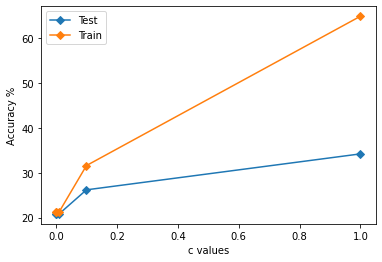

In [10]:
plt.plot(c_values,TestAccuracies,label="Test",marker='D')
plt.plot(c_values,TrainAccuracies,label="Train",marker='D')
plt.xlabel('c values')
plt.ylabel('Accuracy %')
plt.legend()
plt.show()

In [48]:
print("Max accuracy on test: ", maxAcc)
print(bestLR.get_params())

Max accuracy on test:  23.818670764502496
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': 4, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 10, 'warm_start': False}


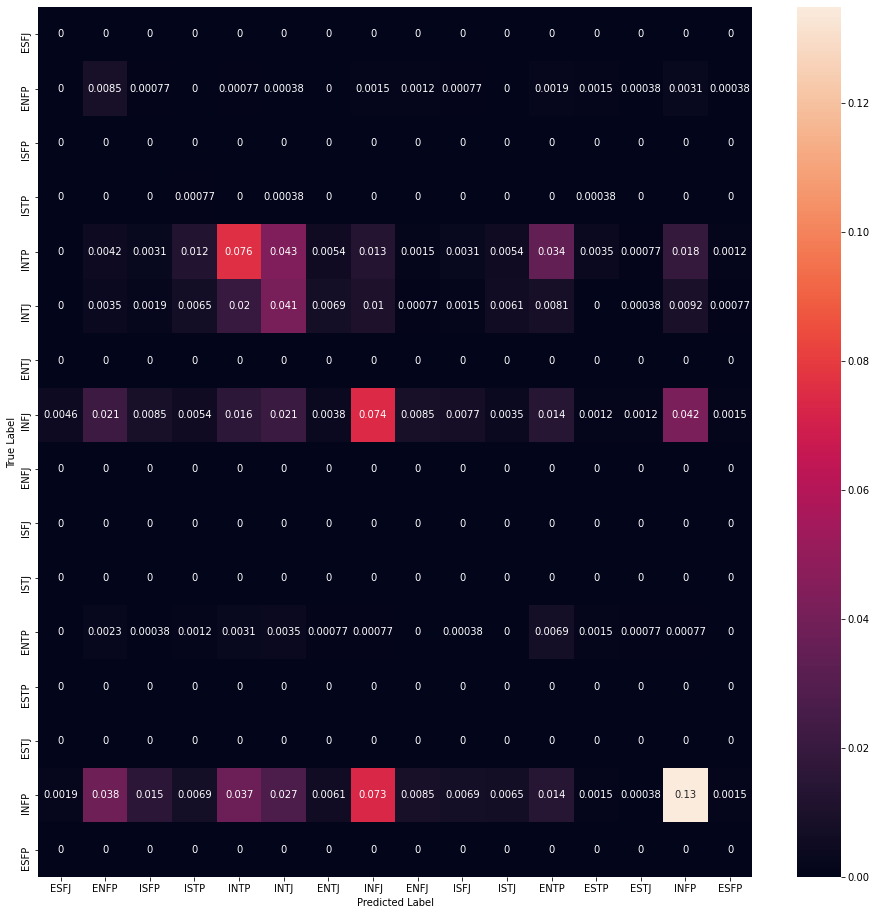

In [41]:
plotConfusionMatrix(bestLR.predict(dfTest), yTest)

### 2. Decision Trees

In [18]:
TestAccuracies = []
TrainAccuracies= []

# Hyperparameter tuning the depth of tree
max_depth = [3, 5, 7, 9, 11, 15, 17, 21]
maxAcc = 0 # Store best accuracy on test
bestDT = None # store best model.

for d in max_depth:
    # train LR
    DT = DecisionTreeClassifier(max_depth=d, random_state=0)
    DT.fit(dfTrain, yTrain)
    
    # find accuracies on train and test sets.
    TrainAccuracies.append(sum(yTrain == DT.predict(dfTrain))/dfTrain.shape[0] * 100)
    TestAccuracies.append(sum(yTest == DT.predict(dfTest))/dfTest.shape[0] * 100)
    
    # If accuracy is better than store this model.
    if maxAcc < sum(yTest == DT.predict(dfTest))/dfTest.shape[0] * 100:
        maxAcc = sum(yTest == DT.predict(dfTest))/dfTest.shape[0] * 100
        bestDT = DT

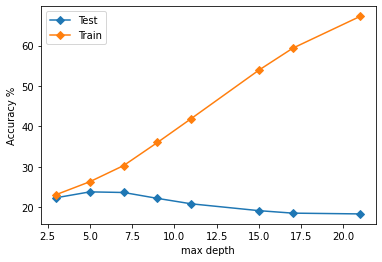

In [19]:
plt.plot(max_depth,TestAccuracies,label="Test",marker='D')
plt.plot(max_depth,TrainAccuracies,label="Train",marker='D')
plt.xlabel('max depth')
plt.ylabel('Accuracy %')
plt.legend()
plt.show()

In [20]:
print("Max accuracy on test: ", maxAcc)
print(bestDT.get_params())

Max accuracy on test:  23.818670764502496
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}


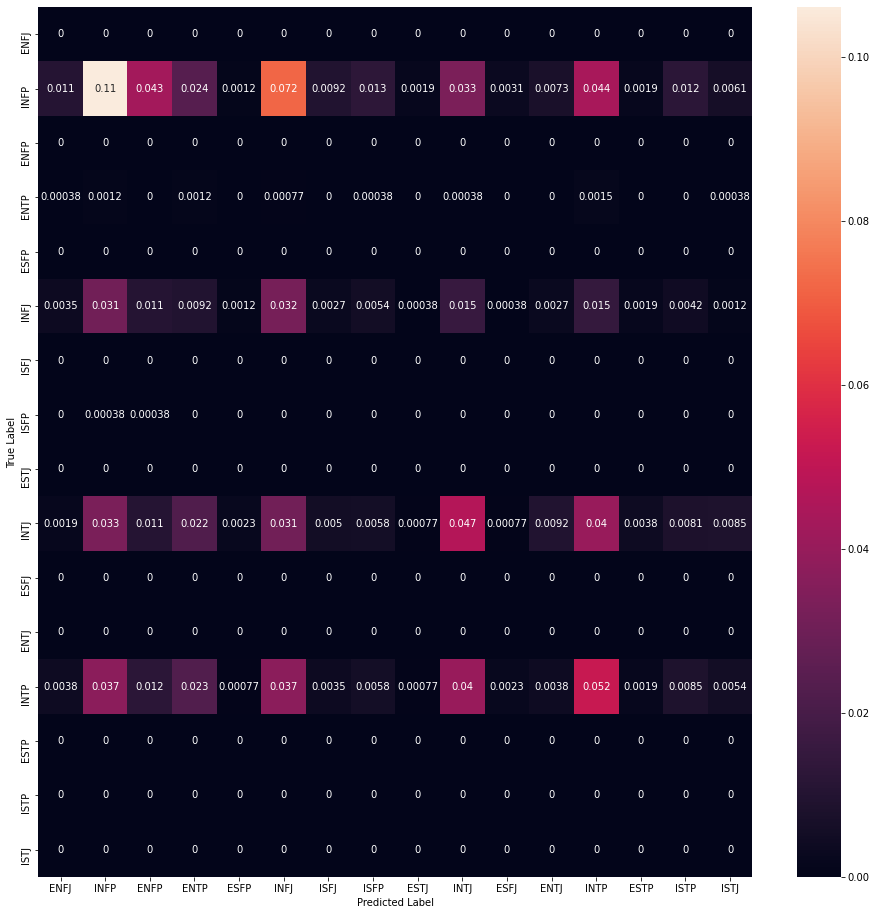

In [21]:
plotConfusionMatrix(bestDT.predict(dfTest), yTest)

## Training with full TFIDF:

### 1. Logistic Regression:

In [7]:
# Build tfIdf features.
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words='english')
dfTrain = vectorizer.fit_transform(dfTrain)
dfTest = vectorizer.transform(dfTest)

In [10]:
TestAccuracies = []
TrainAccuracies= []

# Hyperparameter tuning inverse of learning rate.
c_values = [1.0, 0.0001, 0.001, 0.01, 0.1]
c_values.sort()

bestLR = None # Store best Baseline Model
maxAcc = 0 # Best Accuracy

for c in c_values:
    # train LR
    LR = LogisticRegression(random_state=0, max_iter=100, n_jobs=4, verbose=1, C=c)
    LR.fit(dfTrain, yTrain)
    
    # find accuracies on train and test sets.
    TrainAccuracies.append(sum(yTrain == LR.predict(dfTrain))/dfTrain.shape[0] * 100)
    TestAccuracies.append(sum(yTest == LR.predict(dfTest))/dfTest.shape[0] * 100)
    
    # If accuracy is better than store this model.
    if maxAcc < sum(yTest == LR.predict(dfTest))/dfTest.shape[0] * 100:
        maxAcc = sum(yTest == LR.predict(dfTest))/dfTest.shape[0] * 100
        bestLR = LR

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   20.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   10.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    9.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   30.2s finished


In [13]:
print("Max accuracy on test: ", maxAcc)

Max accuracy on test:  34.114483288513256


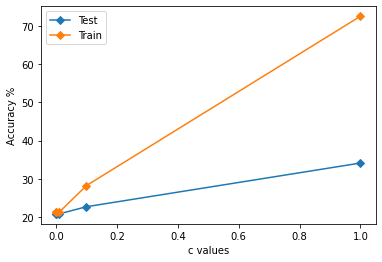

In [11]:
plt.plot(c_values,TestAccuracies,label="Test",marker='D')
plt.plot(c_values,TrainAccuracies,label="Train",marker='D')
plt.xlabel('c values')
plt.ylabel('Accuracy %')
plt.legend()
plt.show()

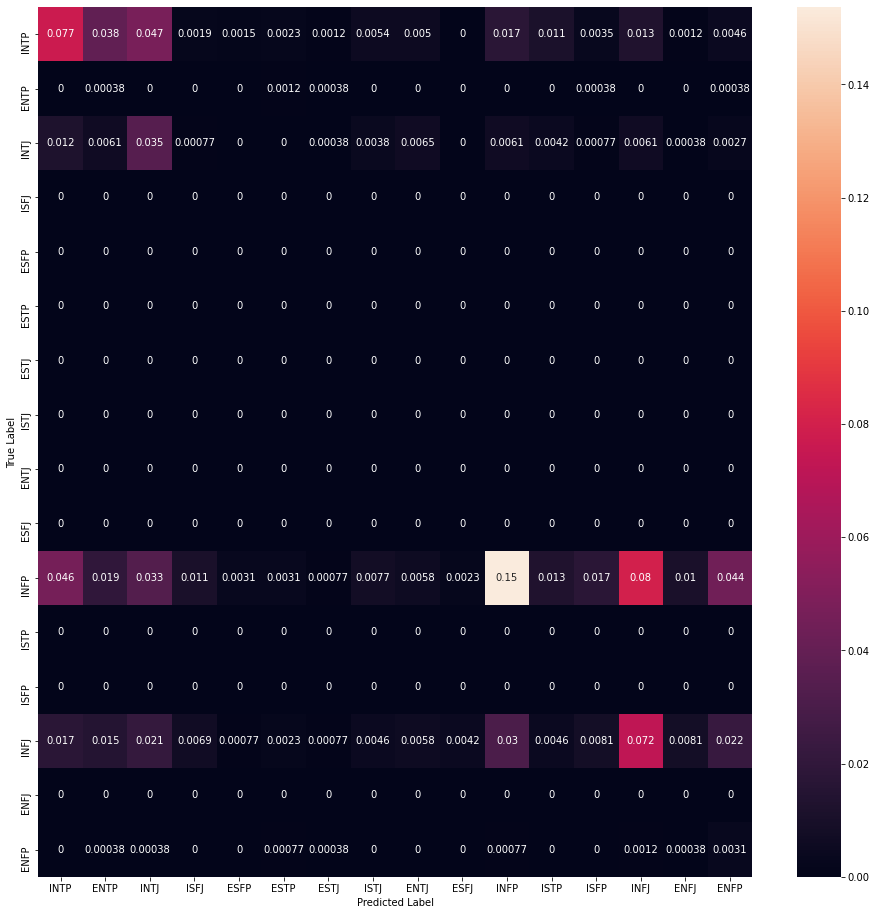

In [12]:
plotConfusionMatrix(bestLR.predict(dfTest), yTest)

### 2. Decision Trees:

In [14]:
TestAccuracies = []
TrainAccuracies= []

# Hyperparameter tuning the depth of tree
max_depth = [3, 5, 7, 9, 11, 15, 17, 21]
maxAcc = 0 # Store best accuracy on test
bestDT = None # store best model.

for d in max_depth:
    # train LR
    DT = DecisionTreeClassifier(max_depth=d, random_state=0)
    DT.fit(dfTrain, yTrain)
    
    # find accuracies on train and test sets.
    TrainAccuracies.append(sum(yTrain == DT.predict(dfTrain))/dfTrain.shape[0] * 100)
    TestAccuracies.append(sum(yTest == DT.predict(dfTest))/dfTest.shape[0] * 100)
    
    # If accuracy is better than store this model.
    if maxAcc < sum(yTest == DT.predict(dfTest))/dfTest.shape[0] * 100:
        maxAcc = sum(yTest == DT.predict(dfTest))/dfTest.shape[0] * 100
        bestDT = DT

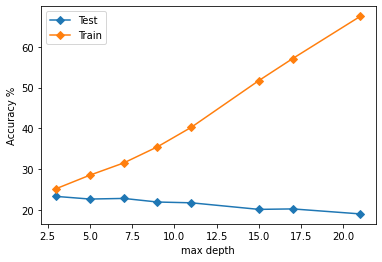

In [15]:
plt.plot(max_depth,TestAccuracies,label="Test",marker='D')
plt.plot(max_depth,TrainAccuracies,label="Train",marker='D')
plt.xlabel('max depth')
plt.ylabel('Accuracy %')
plt.legend()
plt.show()

In [16]:
print("Max accuracy on test: ", maxAcc)
print(bestDT.get_params())

Max accuracy on test:  23.280829811755666
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}


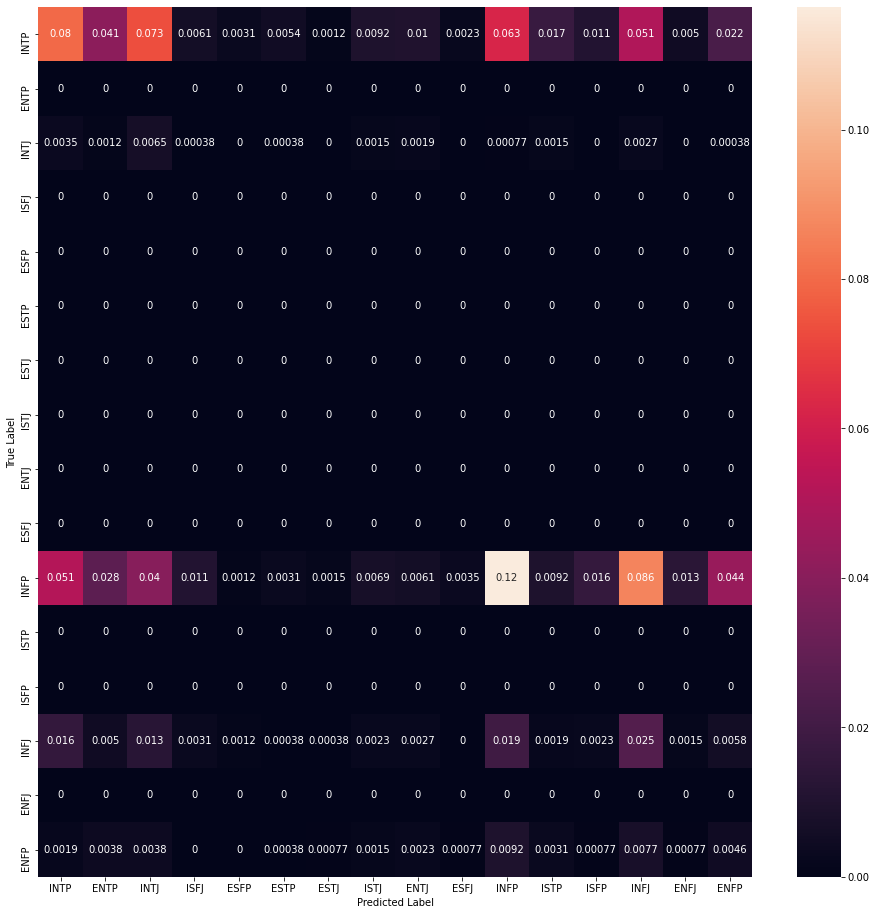

In [17]:
plotConfusionMatrix(bestDT.predict(dfTest), yTest)

### 3. Random Forest:

In [23]:
TestAccuracies = []
TrainAccuracies= []

# max depth
max_depth = [3, 5, 7, 9, 11, 15, 17, 21]

bestRF = None # Store best Baseline Model
maxAcc = 0 # Best Accuracy

for md in max_depth:
    # train LR
    RF = RandomForestClassifier(random_state=0, max_depth=md)
    RF.fit(dfTrain, yTrain)
    
    # find accuracies on train and test sets.
    TrainAccuracies.append(sum(yTrain == RF.predict(dfTrain))/dfTrain.shape[0] * 100)
    TestAccuracies.append(sum(yTest == RF.predict(dfTest))/dfTest.shape[0] * 100)
    
    # If accuracy is better than store this model.
    if maxAcc < sum(yTest == RF.predict(dfTest))/dfTest.shape[0] * 100:
        maxAcc = sum(yTest == RF.predict(dfTest))/dfTest.shape[0] * 100
        bestRF = RF

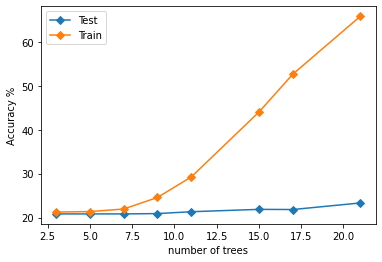

In [24]:
plt.plot(max_depth,TestAccuracies,label="Test",marker='D')
plt.plot(max_depth,TrainAccuracies,label="Train",marker='D')
plt.xlabel('max depth')
plt.ylabel('Accuracy %')
plt.legend()
plt.show()

In [25]:
print("Max accuracy on test: ", maxAcc)

Max accuracy on test:  23.319247022666154


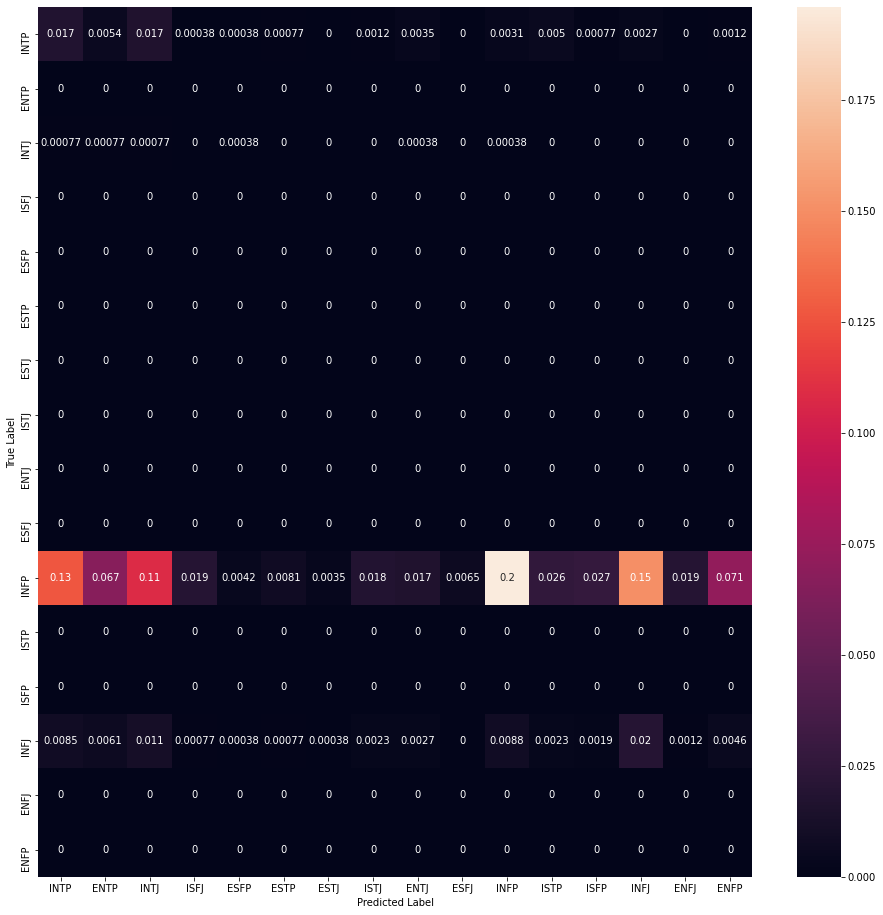

In [26]:
plotConfusionMatrix(bestRF.predict(dfTest), yTest)

### 4. XGBoost:

In [28]:
TestAccuracies = []
TrainAccuracies= []

# max depth
max_depth = [3, 5, 7, 9, 11]

bestXGB = None # Store best Baseline Model
maxAcc = 0 # Best Accuracy

for md in max_depth:
    # train LR
    XGB = XGBClassifier(random_state=0, max_depth=md)
    XGB.fit(dfTrain, yTrain)
    
    # find accuracies on train and test sets.
    TrainAccuracies.append(sum(yTrain == XGB.predict(dfTrain))/dfTrain.shape[0] * 100)
    TestAccuracies.append(sum(yTest == XGB.predict(dfTest))/dfTest.shape[0] * 100)
    
    # If accuracy is better than store this model.
    if maxAcc < sum(yTest == XGB.predict(dfTest))/dfTest.shape[0] * 100:
        maxAcc = sum(yTest == XGB.predict(dfTest))/dfTest.shape[0] * 100
        bestXGB = XGB

/opt/homebrew/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:34:41] WARNING: /private/var/folders/s6/97rzy6yd76d5rd9fldl8x4dc0000gn/T/pip-install-kup6t6wv/xgboost_2cae17b6169b4faa8df9e40373c29caa/build/temp.macosx-11-arm64-3.9/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:35:51] WARNING: /private/var/folders/s6/97rzy6yd76d5rd9fldl8x4dc0000gn/T/pip-install-kup6t6wv/xgboost_2cae17b6169b4faa8df9e40373c29caa/build/temp.macosx-11-arm64-3.9/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:37:39] WARNING: /private/var/folders/s6/97rzy6yd76d5rd9fldl8x4dc0000gn/T/pip-install-kup6t6wv/xgboost_2cae17b6169b4faa8df9e40373c29caa/build/temp.macosx-11-arm64-3.9/xgboost/src/le

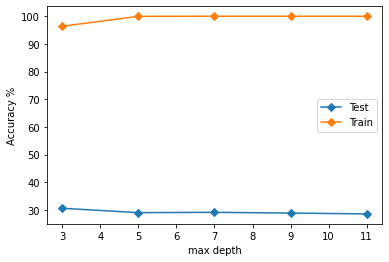

In [29]:
plt.plot(max_depth,TestAccuracies,label="Test",marker='D')
plt.plot(max_depth,TrainAccuracies,label="Train",marker='D')
plt.xlabel('max depth')
plt.ylabel('Accuracy %')
plt.legend()
plt.show()

In [30]:
print("Max accuracy on test: ", maxAcc)

Max accuracy on test:  30.618517095658852


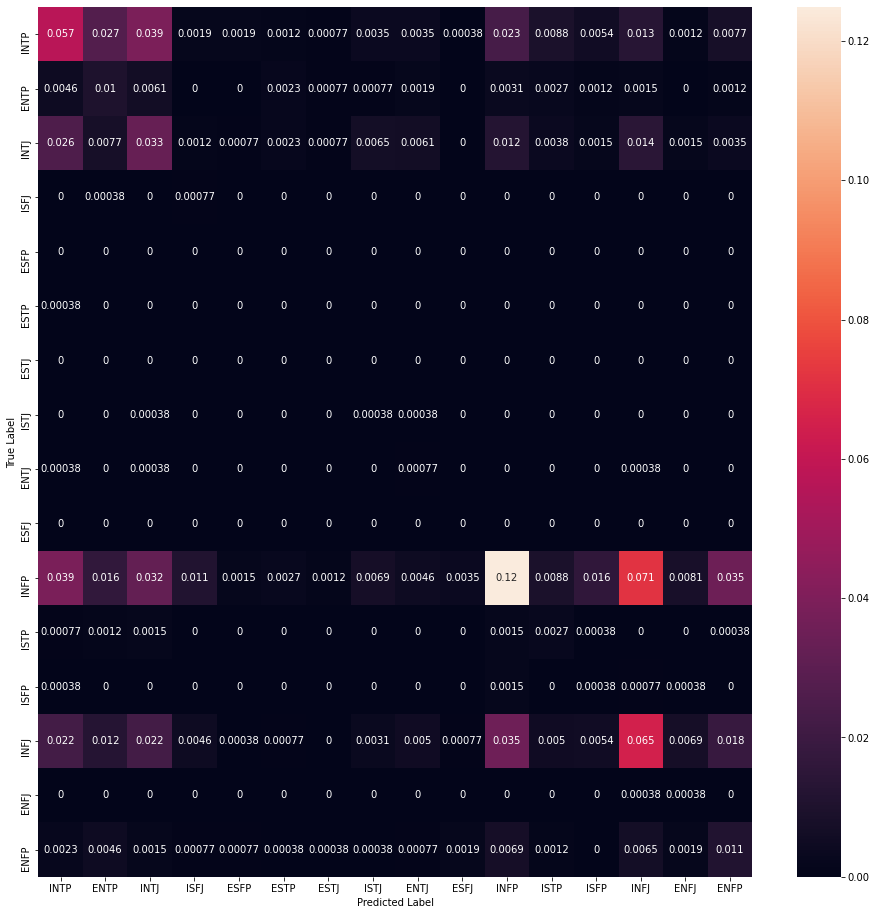

In [31]:
plotConfusionMatrix(bestXGB.predict(dfTest), yTest)